In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
import sys
import os
from os import listdir
from os.path import join
IN_COLAB = 'google.colab' in sys.modules

yolo_dataset_path = ''
if IN_COLAB:
  #Colab
  print('Using Google Colab')
  input_dataset_path = kagglehub.dataset_download('arct22/codebrim-balanced')
  yolo_dataset_path = '/content/'
  print(input_dataset_path)
  print('Data source import complete.')
  print(listdir(input_dataset_path))
    
elif sys.platform == 'linux':
  # Kaggle
  print('Using Kaggle Kernel')
  input_dataset_path = '/kaggle/input/codebrim-balanced'
  yolo_dataset_path = join(os.getcwd(), r'datasets/codebrim-balanced')
  os.makedirs(yolo_dataset_path, exist_ok=True)
  print('Data source import complete.')
  print(os.listdir(input_dataset_path))

else:
  # Windows
  print(f'Using Local Machine. Operating System: {sys.platform}')
  input_dataset_path = join(os.getcwd(), r'kaggle\input\codebrim-balanced') if os.path.exists(join(os.getcwd(), r'kaggle\input\codebrim-balanced')) else ValueError

  print('Data source import complete.')
  print(f'input dataset path: {join(os.getcwd(),input_dataset_path)} \ncontents: ',listdir(input_dataset_path))
  print(f'yolo dataset path: {join(os.getcwd(),yolo_dataset_path)}')


input_train_images = join(input_dataset_path, 'train', 'defects')
input_test_images = join(input_dataset_path, 'test', 'defects')
input_val_images = join(input_dataset_path, 'val', 'defects')

yolo_train_images = join(yolo_dataset_path, 'images', 'train')
yolo_test_images = join(yolo_dataset_path, 'images', 'test')
yolo_val_images = join(yolo_dataset_path, 'images', 'val')

In [1]:
import os

In [ ]:
if sys.platform == 'linux' or sys.platform == 'linux2':
    !pip install -U albumentations
    !pip install xmltodict
    !pip install ultralytics
from ultralytics import settings

if IN_COLAB:
    
  settings.update({'datasets_dir': yolo_dataset_path})

  settings.update({'weights_dir': os.join.path('/kaggle/working/weights')})
  settings.update({'runs_dir': os.join.path('/kaggle/working/runs')})

print(settings)
import os
import shutil
from ultralytics import YOLO
cwd = os.getcwd()
print(cwd)

In [ ]:
# @title
import cv2
import albumentations as A
from tqdm import tqdm
def pad_and_resize(target_width: int, target_height: int, input_path: str, output_path: str) -> None:
  imgs = os.listdir(input_path)

  os.makedirs(output_path, exist_ok=True)
  for img_name in tqdm(imgs):
      if not img_name.endswith(('.jpg', '.png')):
          continue

      img = cv2.imread(os.path.join(input_path, img_name))
      shape = img.shape
      height = shape[0]
      width = shape[1]

      pipeline = 0
      if height > width:
          pipeline = A.Compose([
              A.PadIfNeeded(width, width),
              A.Resize(640, 640)
      ])
      else:
          pipeline = A.Compose([
              A.PadIfNeeded(height, height),
              A.Resize(640, 640)
          ])

      transformed = pipeline(image=img)
      cv2.imwrite(os.path.join(output_path, img_name), transformed['image'])

  print(f'{len(os.listdir(output_path))} images padded, resized to w:{target_width}, h:{target_height} and saved in dir {output_path}')

In [ ]:
for img_dir in ['train', 'test', 'val']:
    print('padding and resizing: ', join(input_dataset_path, img_dir, 'defects'))
    pad_and_resize(640, 640, join(input_dataset_path, img_dir, 'defects'), join(yolo_dataset_path,'images', img_dir))
    print('padding and resizing: ', join(input_dataset_path, img_dir, 'background'))
    pad_and_resize(640, 640, join(input_dataset_path, img_dir, 'background'), join(yolo_dataset_path,'images', img_dir))


In [ ]:
import xmltodict

xml = ''
with open(os.path.join(input_dataset_path, 'metadata/defects.xml'), 'r') as file:
    xml = file.read()

defects_json = xmltodict.parse(xml)
defects_json = defects_json.get('Annotation').get('Defect')

bg_json = xmltodict.parse(xml)
bg_json = bg_json.get('Annotation').get('Defect')

import pandas as pd

defects_df = pd.DataFrame(defects_json)
bg_df = pd.DataFrame(bg_json)
defects_df = pd.concat([defects_df, bg_df])

In [ ]:
defect_labels_arr = defects_df.to_numpy()
defect_imgs ={
    'train': os.listdir(yolo_train_images),
    'test': os.listdir(yolo_test_images),
    'val': os.listdir(yolo_val_images)
}

defect_labels_dict = {
    'train': [],
    'test': [],
    'val': []
    }

for defect in defect_labels_arr:
    if defect[0] in defect_imgs['train']:
        defect_labels_dict['train'].append(defect.tolist())
    elif defect[0] in defect_imgs['test']:
        defect_labels_dict['test'].append(defect.tolist())
    else:
        defect_labels_dict['val'].append(defect.tolist())

In [ ]:
def get_label_in_yolo_format(mhot_labels):
    x_center = 0.5
    y_center = 0.5

    present_labels = []
    i = 0
    for val in mhot_labels:
        if val.isdigit():
            if int(val) == 1:
                present_labels.append(i)
            i += 1

    out_list = []
    for label in present_labels:
        out_list.append(" ".join(map(str, [label, 0.5, 0.5, 1, 1])))

    return out_list

yolo_labels_dir = join(yolo_dataset_path, 'labels')
example_label_yolo = get_label_in_yolo_format(defect_labels_dict['train'][0])

In [ ]:
for label_dir in defect_labels_dict.keys():
    defects = defect_labels_dict[label_dir]
    os.makedirs(os.path.join(yolo_labels_dir, label_dir), exist_ok=True)
    for row in defects:
        filepath = os.path.join(yolo_labels_dir, label_dir, row[0].split('.')[0] + '.txt')
        yolo_label = get_label_in_yolo_format(row)

        with open(filepath, 'w') as file:
            for label in yolo_label:
                file.write(label + '\n')
    #print(label_dir, defects)


In [ ]:
with open('yolo_balanced.yaml', 'w') as f:
    s = """# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: codebrim-balanced # dataset root dir
train: images/train # train images (relative to 'path') 4 images
val: images/val # val images (relative to 'path') 4 images
test: images/test # test images (optional)

# Classes (80 COCO classes)
names:
  0: Background
  1: Crack
  2: Spallation
  3: Efflorescence
  4: ExposedBars
  5: CorrosionStain"""

    f.write(s)


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

# Train the model with 2 GPUs
results = model.train(data=os.path.join(os.getcwd(), 'yolo_balanced.yaml'), epochs=100, imgsz=640, device=[0, 1])

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.62 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/yolo_balanced.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dro

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

/bin/bash: line 1: yolo: command not found


train_batch1.jpg


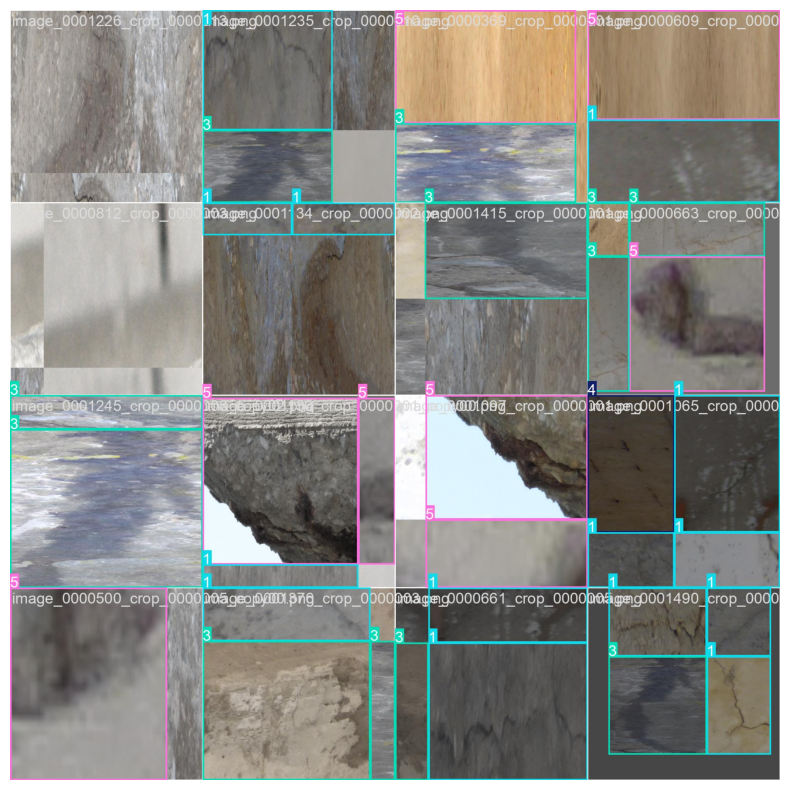


labels.jpg


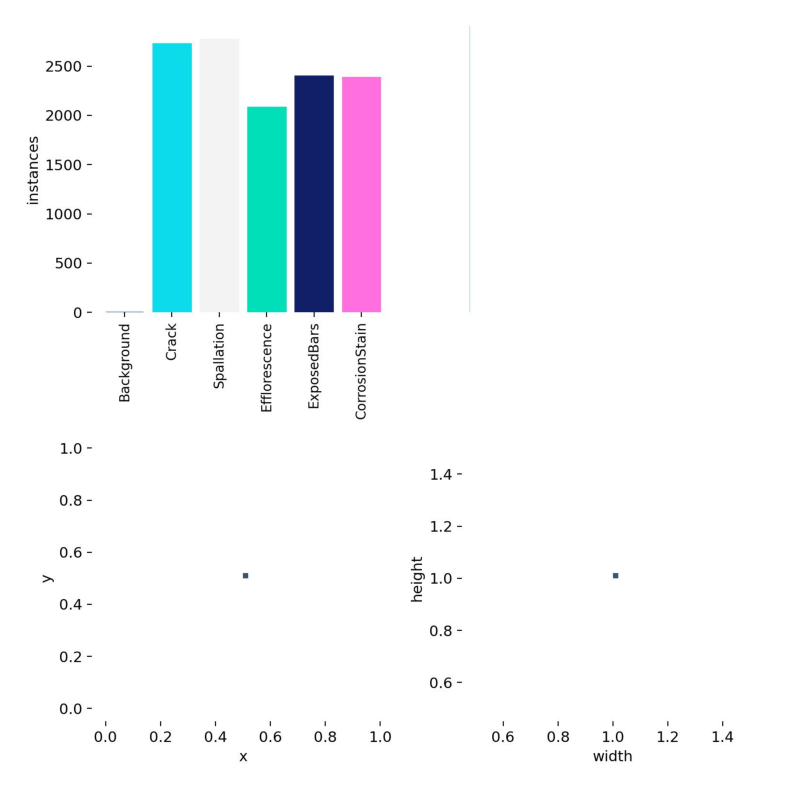


train_batch0.jpg


<Figure size 1000x1000 with 0 Axes>

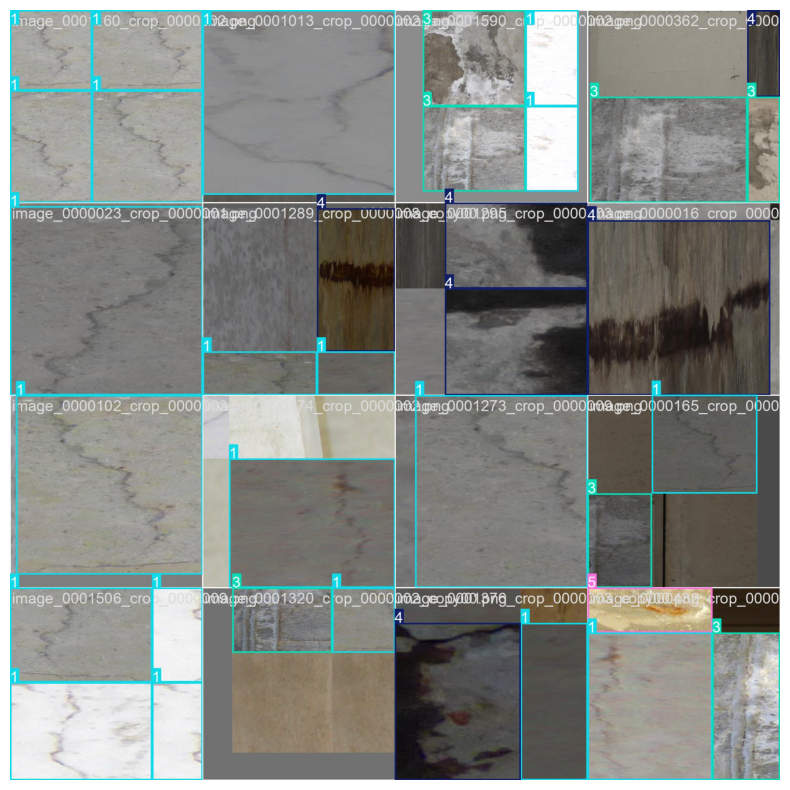


labels_correlogram.jpg


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

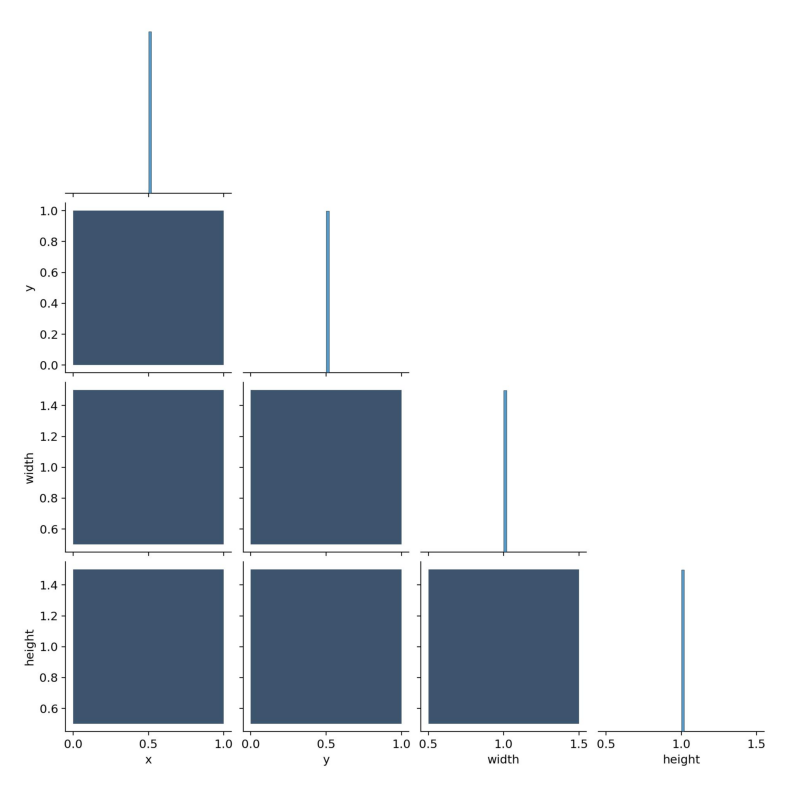


train_batch2.jpg


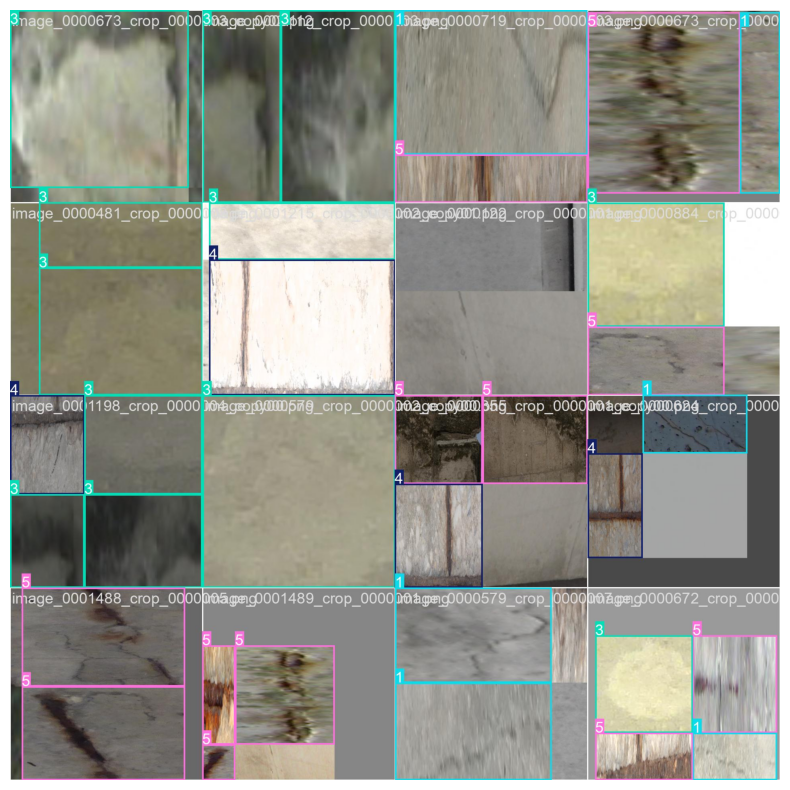

In [47]:
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

def all_subdirs_of(b="."):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
  return result


train_results_path = max(all_subdirs_of(os.path.join(os.getcwd(), r'runs/detect')), key=os.path.getmtime)
train_results = os.listdir(os.path.join(train_results_path))


for img_path in train_results:
    plt.figure(figsize=(10, 10))

    if img_path.endswith('.png') or img_path.endswith('.jpg'):
        print(img_path)
        img = np.asarray(Image.open(os.path.join(train_results_path, img_path)))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print()

